# __Application of a PCM to the argo reference data base__

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr), Cécile Cabanes (cecile.cabanes@ifremer.fr) and Guillaume Maze (gmaze@ifremer.fr)
***

## Description

**The aim of this notebook is to apply a Profile Clasification Model (PCM) to the reference profiles chosen by OWC software for correcting an specific profile.** 

The profile WMO is chosen below and the reference profiles comes from the argo reference database. All paths are read from the ow_config.txt file. The notebook produce a .txt including class labels than can be read for the modified version of OWC included in thsi repository. 
The PCM allows to classify oceanographic profiles depending on its shape (look at BlueCloud notebooks). By using the output of this notebooks in the OWC software, only reference profiles in the same class than de float profiles are used to evaluated it, so profiles in the same dynamic region.

***
This notebook has been developed at Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Euro-ArgoRISE project. This project has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement no 824131. Call INFRADEV-03-2018-2019: Individual support to ESFRI and other world-class research infrastructures.

<div>
<center>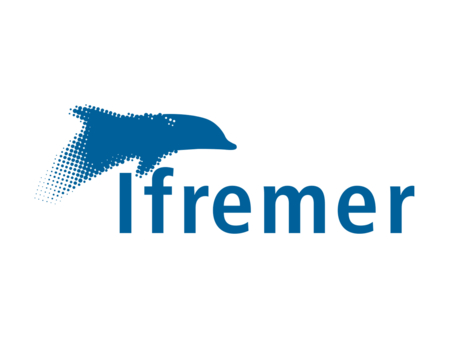 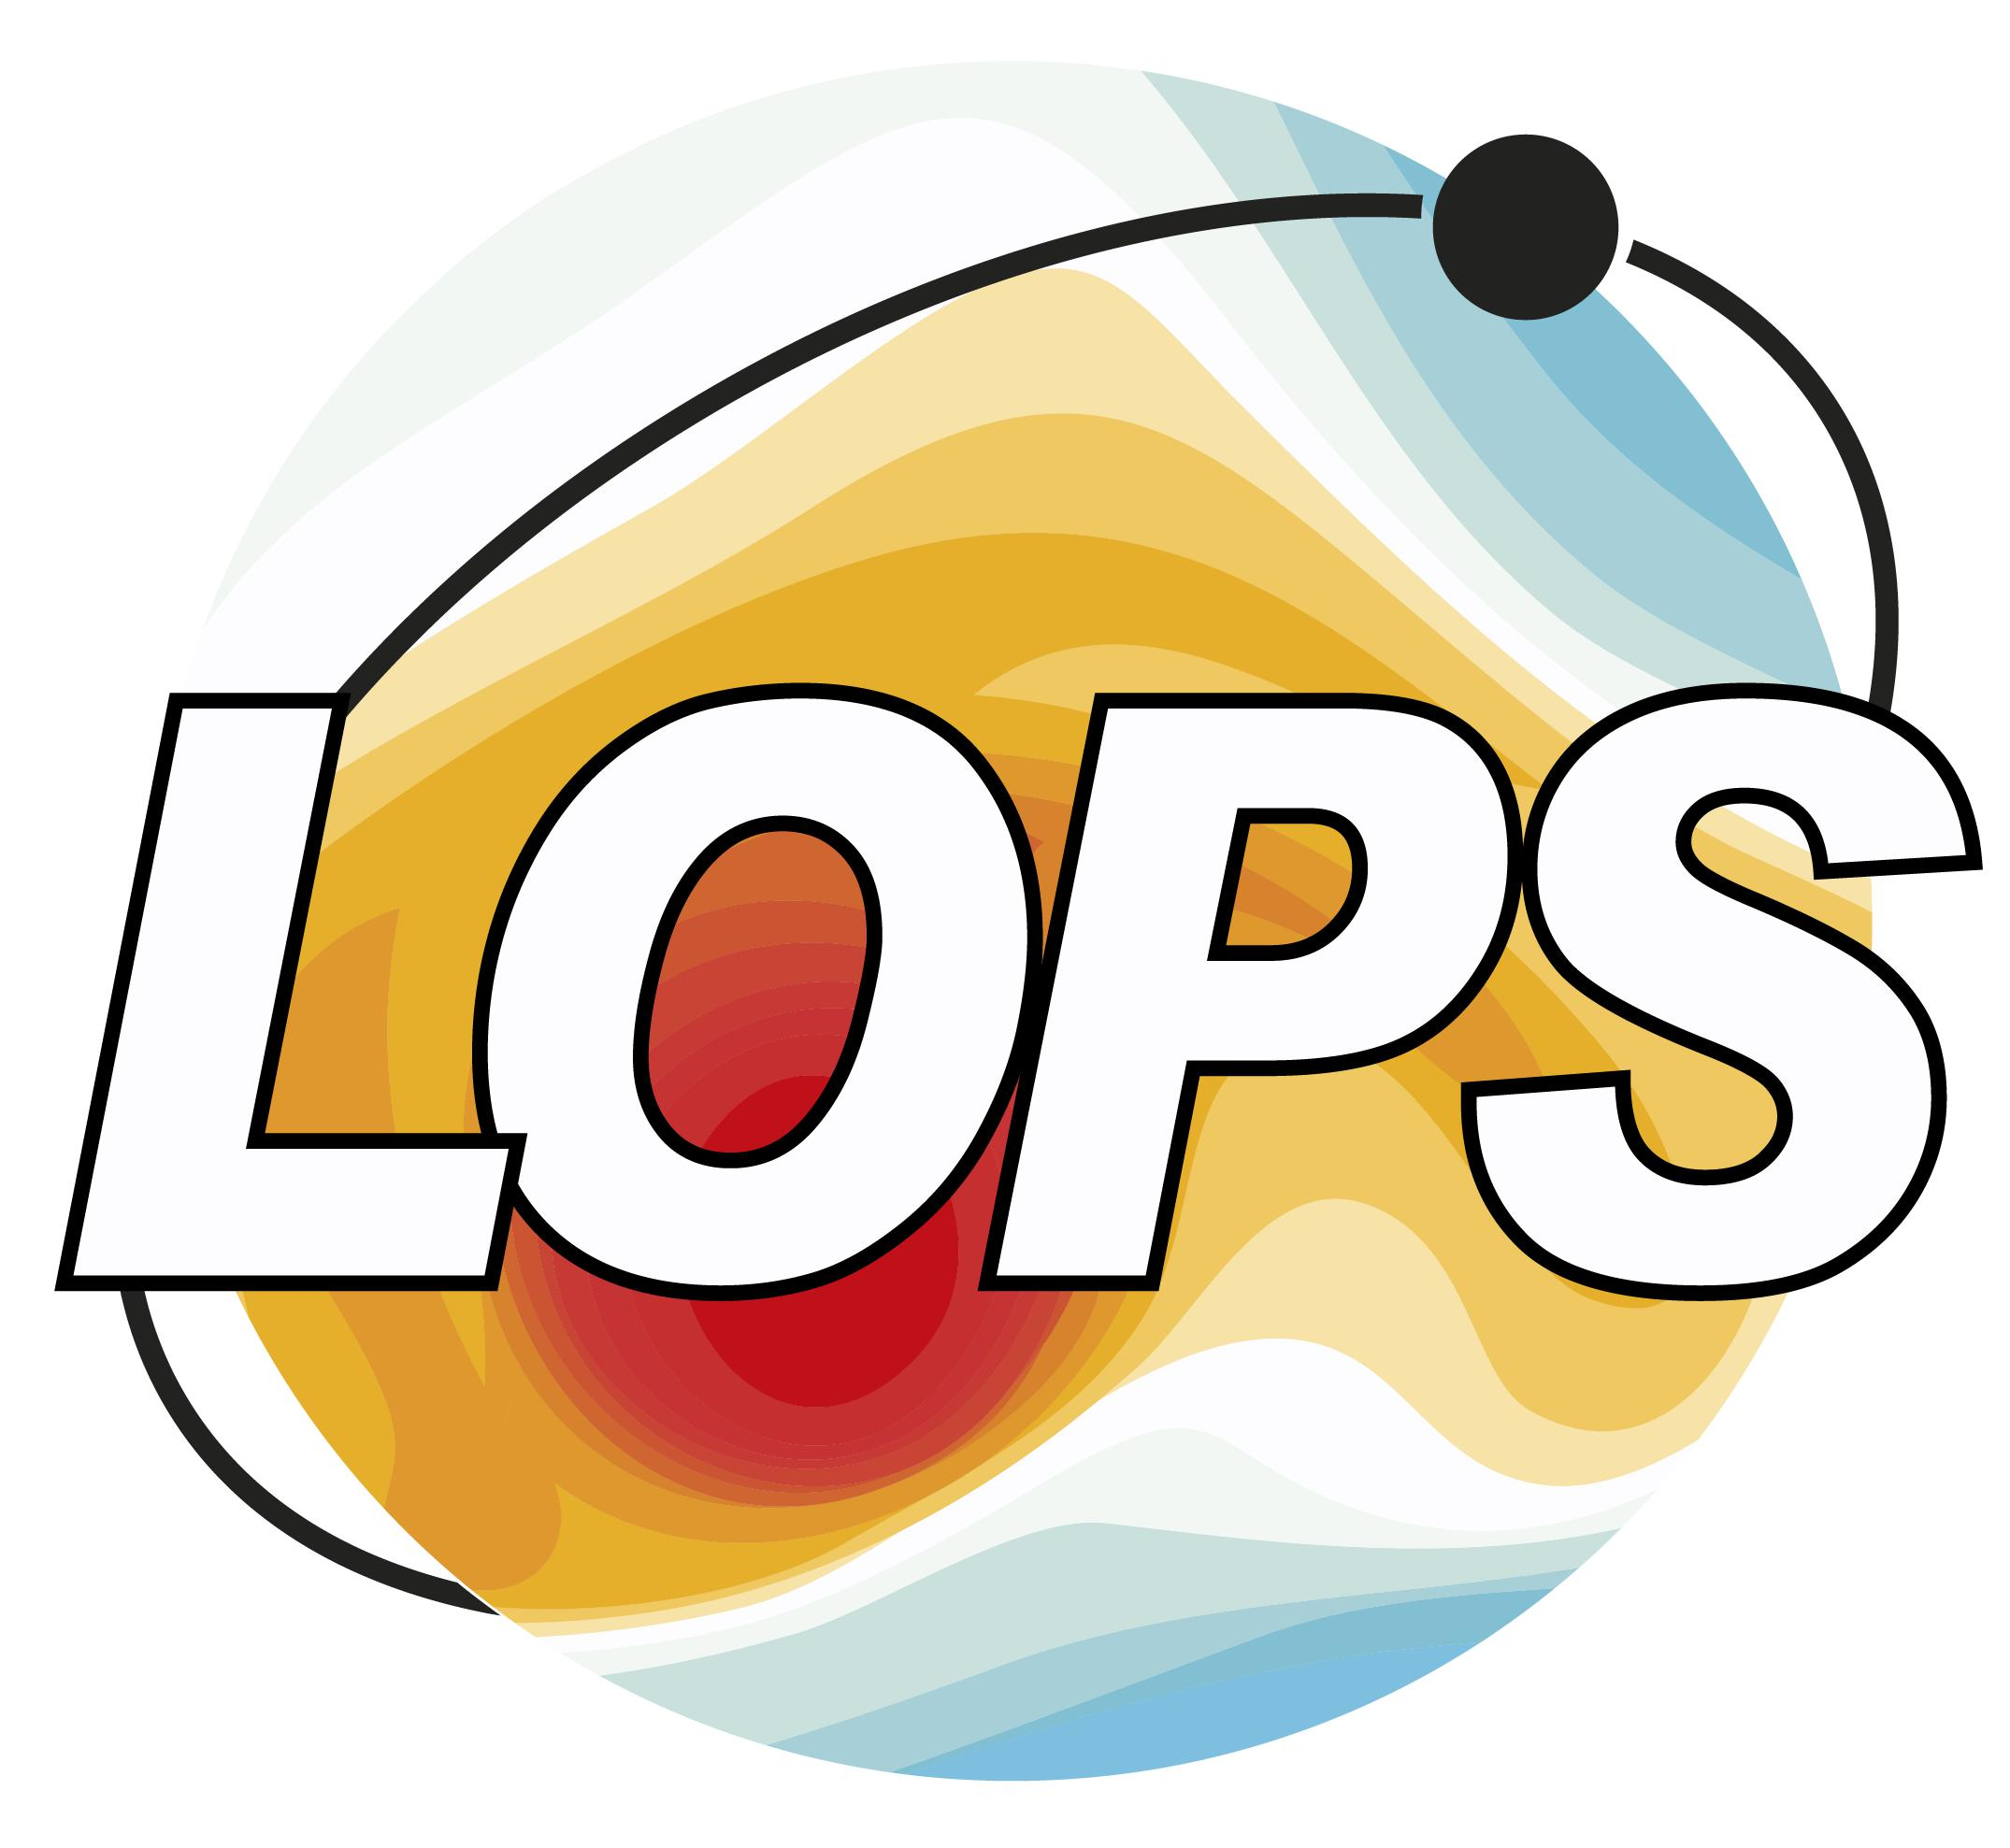 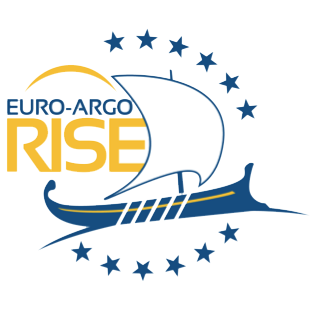</center>
</div>

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma

import pyxpcm
from pyxpcm.models import pcm

import Plotter
from Plotter import Plotter

from classif_functions import *
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import configparser

## User inputs
***

In this section, ...

__1. Configuration file__

Paths are read from the OWC configuration file. You should give the path to this file.

In [2]:
config_filename = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/ow_config.txt'

__2. Interpolation depth__

The model can not cope with NaNs should data should be interpolated to the same levels and profiles that are too short will be deleted. Please, choose the max_depth below. We recomend a value around 1000 m, to take into account an important part of the water column in the classification.

In [3]:
# depth for interpolation
max_depth = 900

__3. Season__

Maybe usefull for decorrelation of the training dataset

In [4]:
# chose season ('DJF', 'MAM', 'JJA', 'SON' or 'all') for training dataset
season = ['all']

__4. Float WMO__

Float you want to correct

In [5]:
# Galicia
#float_mat_path = config['float_source_directory'] + '/test4/6900230.mat'
#float_WMO = 6900230
# agulhas current
#float_mat_path = config['float_source_directory'] + '/test3/3901915.mat'
#float_WMO = 3901915
# southern ocean
#float_mat_path = config['float_source_directory'] + '/test2/3901928.mat'
#float_WMO = 3901928
# north atlantic 
#float_mat_path = '/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/OWC-pcm/matlabow/data/float_source/test1/4900136.mat'
float_WMO = 4900136

__5. Model parameters__

Please choose the number of classes. You can have un idea of the best number of classes in your dataset by using the BIC_calculation notebook

In [6]:
K=4 # number of classes

## 1. Load argo reference database
***

Important paths are readed form the config file and data is loaded from the argo reference database

__Read OWC configuration file__

In [7]:
with open(config_filename) as f:
    file_content = '[configuration]\n' + f.read()

config_parser = configparser.RawConfigParser(comment_prefixes='%')
config_parser.read_string(file_content)
config = config_parser['configuration']

The paths are automatically assigned using the OW configuration file. You can change the paths if neaded

In [8]:
#wmo_boxes= config['config_directory'] + config['config_wmo_boxes']
wmo_boxes='wmo_boxes_argo.mat'
#ref_path = '/home1/homedir5/perso/agarciaj/EARISE/OW/matlabow/data/climatology/'
ref_path = config['historical_directory']
float_mat_path = config['float_source_directory'] + '/test1/' + str(float_WMO)+ '.mat'

__Load argo reference database__

Talk about ellipses and PV option

In [9]:
ds = get_refdata(float_mat_path = float_mat_path, 
                 WMOboxes_latlon = 'WMO_boxes_latlon.txt', 
                 wmo_boxes = wmo_boxes, 
                 ref_path = ref_path,
                 config = config,
                 map_pv_use = 0)

/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7307.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7207.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7506.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7406.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7306.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7206.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7505.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7405.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7305.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7205.mat
/home5/pharos/argo/DMARGO/OW/VERSION_LAST/data/climatology//argo_profiles/argo_7504.mat
/home5/pharos/argo/DMARGO/OW/VER

In [10]:
print(ds)

<xarray.Dataset>
Dimensions:     (n_pres: 1049, n_profiles: 22686)
Coordinates:
    long        (n_profiles) float64 289.8 289.6 289.7 ... 320.9 321.0 320.9
    lat         (n_profiles) float64 34.19 34.17 34.42 34.55 ... 29.1 29.43 29.8
    dates       (n_profiles) datetime64[ns] 2011-10-26T05:09:18 ... 2013-08-0...
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 22681 22682 22683 22684 22685
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
Data variables:
    pres        (n_pres, n_profiles) float64 4.12 4.16 4.11 4.4 ... nan nan nan
    temp        (n_pres, n_profiles) float64 25.17 24.63 24.09 ... nan nan nan
    sal         (n_pres, n_profiles) float64 36.52 36.46 36.45 ... nan nan nan
    source      (n_profiles) <U46 '1901378_157.STEPHENRISER,KENNETHJOHNSON' ....
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0


## 2. Create training dataset
***

In this section, ..

__Regular sampling__

You should choose the correlation distance. If you do not want to make the regular sample or the dataset is very big you can make ds_t = ds. If the dataset is to big it will take very long time and you need a lot of RAM memory.

In [11]:
%%time
corr_dist = 50 # in km
ds_t = get_regulargrid_dataset(ds, corr_dist, season=season)

no more points to delate
1798
CPU times: user 58.7 s, sys: 2.47 s, total: 1min 1s
Wall time: 1min 1s


In [12]:
print(ds_t)

<xarray.Dataset>
Dimensions:     (n_pres: 1049, n_profiles: 1799)
Coordinates:
    long        (n_profiles) float64 288.1 289.5 286.3 ... 322.4 320.1 320.8
    lat         (n_profiles) float64 34.54 37.31 32.14 ... 29.93 29.18 28.98
    dates       (n_profiles) datetime64[ns] 2011-10-08T10:47:58 ... 2013-05-2...
  * n_profiles  (n_profiles) int64 12 23 49 64 69 ... 22632 22637 22649 22682
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
Data variables:
    pres        (n_pres, n_profiles) float64 5.0 5.0 1.0 5.0 ... nan nan nan nan
    temp        (n_pres, n_profiles) float64 25.26 20.84 19.62 ... nan nan nan
    sal         (n_pres, n_profiles) float64 36.43 36.49 36.57 ... nan nan nan
    source      (n_profiles) object '1901465_018.BRECKOWENS' ... '6901220_036...
    mask_s      (n_profiles) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1

__Interpolate to standard levels__

We use max depth in this section

In [13]:
ds_t = interpolate_standard_levels(ds_t, std_lev=np.arange(0,max_depth))

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:137: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [14]:
print(ds_t)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 1791)
Coordinates:
    long               (n_profiles) float64 288.1 289.5 286.3 ... 320.1 320.8
    lat                (n_profiles) float64 34.54 37.31 32.14 ... 29.18 28.98
    dates              (n_profiles) datetime64[ns] 2011-10-08T10:47:58 ... 20...
  * n_profiles         (n_profiles) int64 12 23 49 64 ... 22637 22649 22682
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    mask_s             (n_profiles) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pres               (n_profiles, PRES_INTERPOLATED) float64 5.0 5.0 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 36.43 ... 35.31
    source             (n_profiles) object '1901465_018.BRECKOWENS' ... '6901...
    temp               (n_profiles, PRES_INTERPOLATED) float64 25.26 ... 8.61
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    

Quick plot of the profiles in ds_t

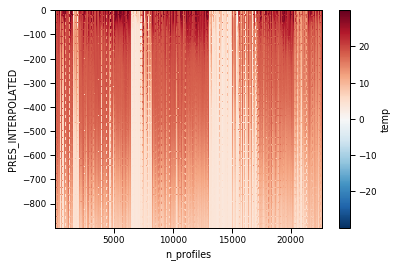

In [15]:
ds_t['temp'].plot(x='n_profiles');

Plot the spatial distribution of training dataset

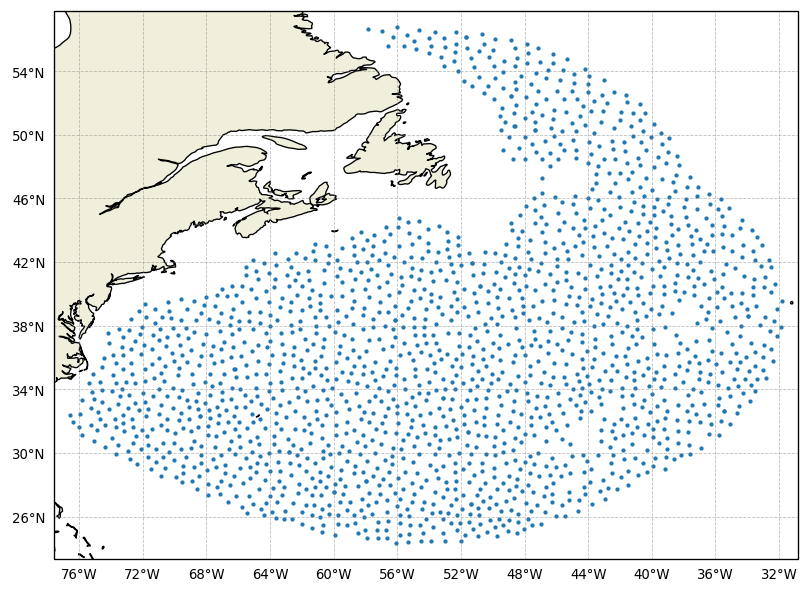

In [16]:
plot_spatialdist_ds(ds_t, float_WMO, float_traj=False)

## 3. Create prediction dataset
***

In this section, ...

__Add float data to initial dataset__

...

In [17]:
ds_p = add_floatdata(float_WMO, float_mat_path, ds)

In [18]:
print(ds_p)

<xarray.Dataset>
Dimensions:     (n_pres: 1049, n_profiles: 22805)
Coordinates:
  * n_profiles  (n_profiles) int64 0 1 2 3 4 5 ... 22800 22801 22802 22803 22804
    long        (n_profiles) float64 289.8 289.6 289.7 ... 307.7 308.9 310.2
    lat         (n_profiles) float64 34.19 34.17 34.42 ... 38.12 38.8 38.67
    dates       (n_profiles) datetime64[ns] 2011-10-26T05:09:18 ... 2005-01-01
  * n_pres      (n_pres) int64 0 1 2 3 4 5 6 ... 1043 1044 1045 1046 1047 1048
Data variables:
    pres        (n_pres, n_profiles) float64 4.12 4.16 4.11 4.4 ... nan nan nan
    temp        (n_pres, n_profiles) float64 25.17 24.63 24.09 ... nan nan nan
    sal         (n_pres, n_profiles) float64 36.52 36.46 36.45 ... nan nan nan
    source      (n_profiles) object '1901378_157.STEPHENRISER,KENNETHJOHNSON'...
    mask_s      (n_profiles) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1

__Interpolate to standard levels__

...

In [19]:
ds_p = interpolate_standard_levels(ds_p, std_lev=np.arange(0,max_depth))

/home1/homedir5/perso/agarciaj/EARISE/DMQC-PCM/PCM-design/classif_functions.py:137: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  remapped = xr.apply_ufunc(_regular_interp, z, data, z_regridded, **kwargs)


In [20]:
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 22757)
Coordinates:
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 22801 22802 22803 22804
    long               (n_profiles) float64 289.8 289.6 289.7 ... 308.9 310.2
    lat                (n_profiles) float64 34.19 34.17 34.42 ... 38.8 38.67
    dates              (n_profiles) datetime64[ns] 2011-10-26T05:09:18 ... 20...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    mask_s             (n_profiles) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pres               (n_profiles, PRES_INTERPOLATED) float64 4.12 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 36.52 ... 35.26
    source             (n_profiles) object '1901378_157.STEPHENRISER,KENNETHJ...
    temp               (n_profiles, PRES_INTERPOLATED) float64 25.17 ... 9.872
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
  

Plot the spatial distribution of prediction dataset

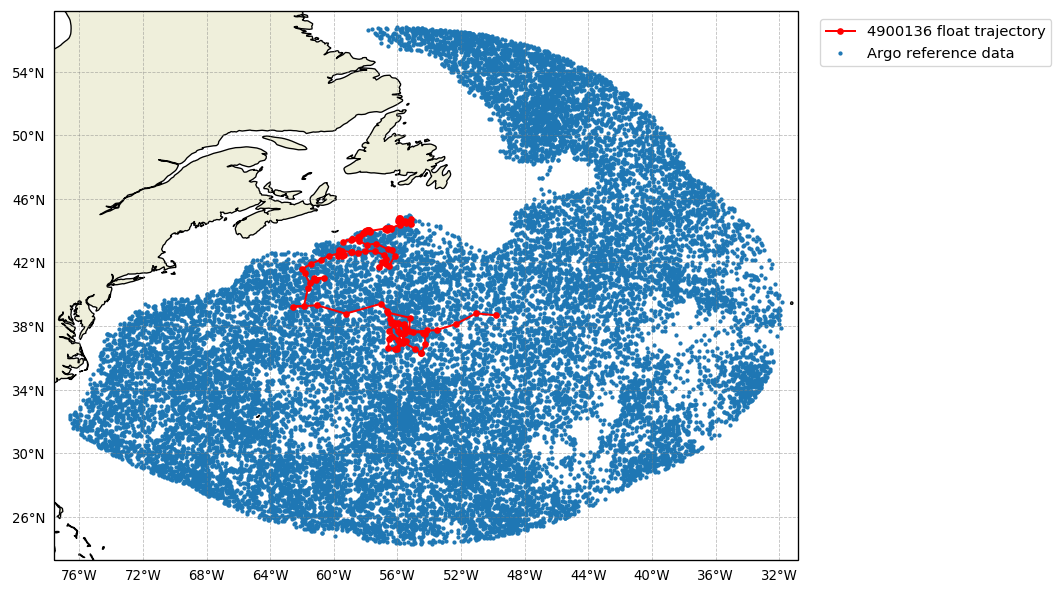

In [21]:
plot_spatialdist_ds(ds_p, float_WMO, float_traj=True)

## 4. Create and apply PCM
***

...

__Train a new model ...__

Create model

In [22]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']

# pcm feature
z = ds_t[z_dim]
pcm_features = {var_name_mdl[0]: z, var_name_mdl[1]: z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 4, F: 2)>
Number of class: 4
Number of feature: 2
Feature names: odict_keys(['temp', 'sal'])
Fitted: False
Feature: 'temp'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

Fit model

In [23]:
var_name_ds = ['temp', 'sal']
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

m.fit(ds_t, features=features_in_ds, dim=z_dim)
m

<pcm 'gmm' (K: 4, F: 2)>
Number of class: 4
Number of feature: 2
Feature names: odict_keys(['temp', 'sal'])
Fitted: True
Feature: 'temp'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'sal'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 38.176781

Save fitted model

In [ ]:
m.to_netcdf('models/model_CTD_3901915_K6_FINAL.nc')

__... or load pre-trained model__

If scarce CTD data you can fit the model with argo data, save it and make the prediction with the CTD data. Front limits can be more accurate.

In [ ]:
z_dim = 'PRES_INTERPOLATED'
var_name_mdl = ['temp', 'sal']
var_name_ds = ['temp', 'sal']
features_in_ds = {var_name_mdl[0] : var_name_ds[0], var_name_mdl[1] : var_name_ds[1]}

In [ ]:
m = pyxpcm.load_netcdf('models/model_CTD_3901915_K6_FINAL.nc')

__Prediction__

Predict labels

In [24]:
m.predict(ds_p, features=features_in_ds, inplace = True)
print(ds_p)

<xarray.Dataset>
Dimensions:            (PRES_INTERPOLATED: 900, n_profiles: 22757)
Coordinates:
  * n_profiles         (n_profiles) int64 0 1 2 3 4 ... 22801 22802 22803 22804
    long               (n_profiles) float64 289.8 289.6 289.7 ... 308.9 310.2
    lat                (n_profiles) float64 34.19 34.17 34.42 ... 38.8 38.67
    dates              (n_profiles) datetime64[ns] 2011-10-26T05:09:18 ... 20...
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
Data variables:
    mask_s             (n_profiles) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pres               (n_profiles, PRES_INTERPOLATED) float64 4.12 ... 899.0
    sal                (n_profiles, PRES_INTERPOLATED) float64 36.52 ... 35.26
    source             (n_profiles) object '1901378_157.STEPHENRISER,KENNETHJ...
    temp               (n_profiles, PRES_INTERPOLATED) float64 25.17 ... 9.872
    PCM_LABELS         (n_profiles) int64 3 3 3 3 3 3 3 3 3 ... 0 3 3 3 3 3 3 3
Attributes:
   

Calculate probability

In [25]:
m.predict_proba(ds_p, features=features_in_ds, dim=z_dim, inplace=True);

Calculate quantile

In [26]:
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[0], outname=var_name_ds[0] + '_Q', keep_attrs=True, inplace=True)
ds_p = ds_p.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=var_name_ds[1], outname=var_name_ds[1] + '_Q', keep_attrs=True, inplace=True)

Calculate robustness

In [27]:
ds_p.pyxpcm.robustness(m, inplace=True)
ds_p.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (PRES_INTERPOLATED: 900, n_profiles: 22757, pcm_class: 4, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3
  * n_profiles          (n_profiles) int64 0 1 2 3 4 ... 22801 22802 22803 22804
    long                (n_profiles) float64 289.8 289.6 289.7 ... 308.9 310.2
    lat                 (n_profiles) float64 34.19 34.17 34.42 ... 38.8 38.67
    dates               (n_profiles) datetime64[ns] 2011-10-26T05:09:18 ... 2...
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    mask_s              (n_profiles) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pres                (n_profiles, PRES_INTERPOLATED) float64 4.12 ... 899.0
    sal                 (n_profiles, PRES_INTERPOLATED) float64 36.52 ... 35.26
    source              (n_profiles) object '1901378_157.STEPHENRISER,KENNETH...
    temp                (n_profiles, PRES_INTERPOLATED) float64 25.17 ... 9.872
    PCM_LABELS          (n_profiles) int64 3 3 3 3 3 3 3 3 3 ... 0 3 3 3 3 3 3 3
    PCM_POST            (pcm_class, n_profiles) float64 5.234e-08 ... 0.9989
    temp_Q              (pcm_class, quantile, PRES_INTERPOLATED) float64 16.6...
    sal_Q               (pcm_class, quantile, PRES_INTERPOLATED) float64 36.0...
    PCM_ROBUSTNESS      (n_profiles) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 0.9985
    PCM_ROBUSTNESS_CAT  (n_profiles) int64 4 4 4 4 4 5 5 4 4 ... 4 4 4 4 4 4 4 4
Attributes:
    __header__:   b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue S...
    __version__:  1.0
    __globals__:  1.0

In [28]:
print(ds_p)

<xarray.Dataset>
Dimensions:             (PRES_INTERPOLATED: 900, n_profiles: 22757, pcm_class: 4, quantile: 3)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3
  * n_profiles          (n_profiles) int64 0 1 2 3 4 ... 22801 22802 22803 22804
    long                (n_profiles) float64 289.8 289.6 289.7 ... 308.9 310.2
    lat                 (n_profiles) float64 34.19 34.17 34.42 ... 38.8 38.67
    dates               (n_profiles) datetime64[ns] 2011-10-26T05:09:18 ... 2...
  * PRES_INTERPOLATED   (PRES_INTERPOLATED) int64 0 -1 -2 -3 ... -897 -898 -899
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    mask_s              (n_profiles) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pres                (n_profiles, PRES_INTERPOLATED) float64 4.12 ... 899.0
    sal                 (n_profiles, PRES_INTERPOLATED) float64 36.52 ... 35.26
    source              (n_profiles) object '1901378_157.STEPHENRISER,KENNETH...
    temp                (n_profi

## 6. Classification plots
***

In this section, ...

__TO DO__: save figures

In [29]:
P = Plotter(ds_p, m, coords_dict= {'latitude': 'lat', 'longitude': 'long', 'time': 'dates'}, cmap_name='tab10')
P.data_type = 'profiles'

__Vertical structure__

...

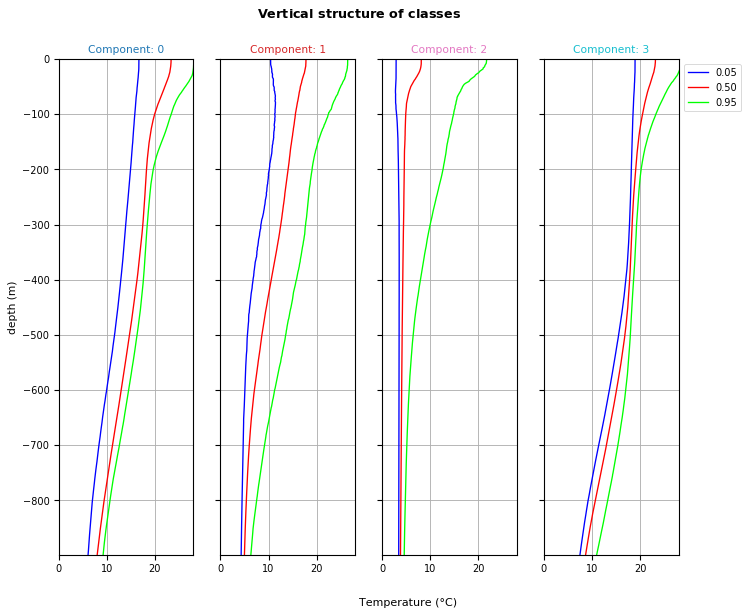

In [30]:
P.vertical_structure(q_variable = var_name_ds[0] + '_Q', sharey=True, xlabel='Temperature (°C)', xlim=[0, 28])

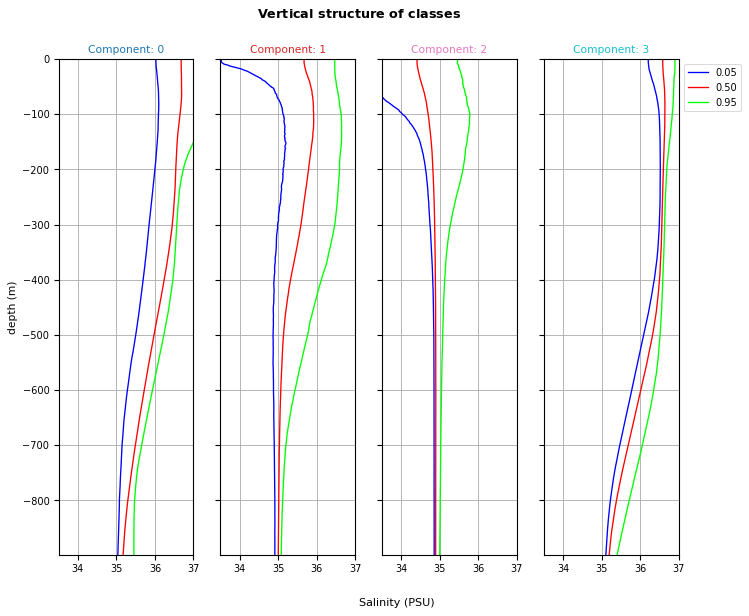

In [31]:
P.vertical_structure(q_variable = var_name_ds[1] + '_Q', sharey=True, xlabel='Salinity (PSU)', xlim=[33.5,37])

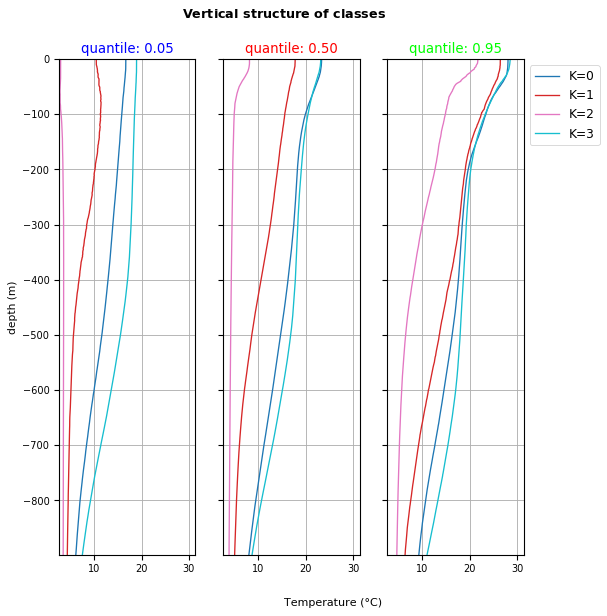

In [32]:
P.vertical_structure_comp(q_variable = var_name_ds[0] + '_Q', plot_q= 'all', xlabel='Temperature (°C)')

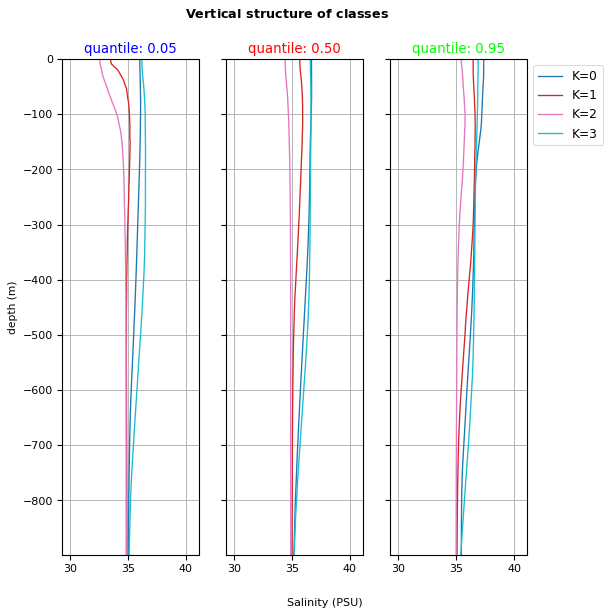

In [33]:
P.vertical_structure_comp(q_variable = var_name_ds[1] + '_Q', plot_q= 'all', xlabel='Salinity (PSU)')

__Spatial distribution__

...

selected_float_30
22715
selected_float_40
22725
selected_float_50
22735
selected_float_60
22745
selected_float_70
22755
selected_float_72
22757
selected_float_80
22765


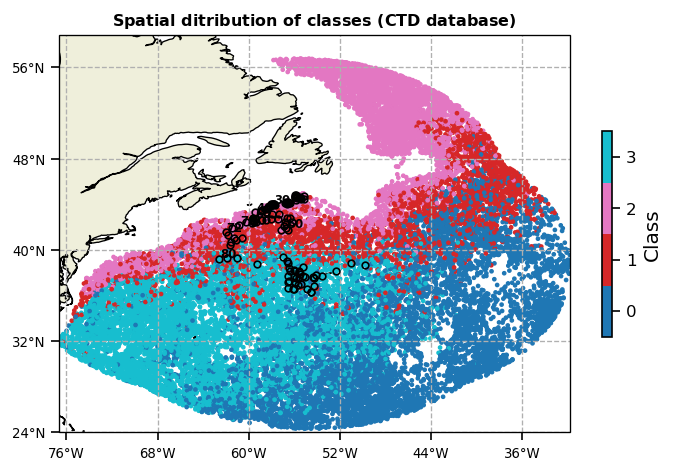

In [34]:
P.spatial_distribution(lonlat_grid =[8,8])

__Float profiles__

...

Float trajectory classes

In [ ]:
selected_float_index = [i for i, isource in enumerate(ds_p['source'].values) if 'selected_float' in isource]

kmap = m.plot.cmap(name='Accent')

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
            12, 12), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

#p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, c=ds_p['PCM_LABELS'], cmap=kmap, transform=proj, label='Argo reference data', alpha=0)

p3 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
                 'k-', transform=proj, zorder=-1)

p2 = ax.scatter(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), s=20, 
                c=ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index), cmap=kmap, transform=proj, vmin=0, vmax=K, zorder=1)
#p1 = ax.scatter(ds_p['long'], ds_p['lat'], s=3, c=ds_p['PCM_LABELS'], cmap=kmap, transform=proj, label='Argo reference data')

#p3 = ax.plot(ds_p['long'].isel(n_profiles = selected_float_index), ds_p['lat'].isel(n_profiles = selected_float_index), 
#                 'b-', transform=proj, markersize = 3, markerfacecolor="None", label = str(float_WMO) + ' float trajectory')

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax.add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax.gridlines(crs=ax.projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 6}
gl.ylabel_style = {'fontsize': 6}
gl.xlabels_top = False
gl.ylabels_right = False
lon_180 = np.mod((ds_p['long'].isel(n_profiles = selected_float_index)+180),360)-180
ax.set_xlim([lon_180.min()-1, lon_180.max()+1])
ax.set_ylim([ds_p['lat'].isel(n_profiles = selected_float_index).min()-1, ds_p['lat'].isel(n_profiles = selected_float_index).max()+1])

cbar = plt.colorbar(p2, shrink=0.2, pad=0.01)
cbar.set_ticks(np.arange(0.5, K+0.5))
cbar.set_ticklabels(range(K))
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Class', fontsize=10)

#plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

Float cycles probability

In [ ]:
float_labels = ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index)
float_post = ds_p['PCM_POST'].isel(n_profiles = selected_float_index, pcm_class = float_labels.astype(np.int16))
float_source = ds_p['source'].isel(n_profiles = selected_float_index)
float_cycles = [int(float_source.values[i].lstrip('selected_float_')) for i in range(len(float_source))]
cycles_labels = np.arange(10,float_cycles[-1],10)

kmap = m.plot.cmap(name='Accent')

fig, ax = plt.subplots(figsize=(30, 10))

rects1 = ax.plot(float_cycles, float_post, '-', zorder=-1)
rects2 = ax.scatter(float_cycles, float_post, s=40, c=float_labels, cmap=kmap, zorder=1, vmin=0, vmax=K)

ax.set_ylabel('Posteriors', fontsize=20)

ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=20)
ax.set_xticks(cycles_labels)
ax.set_xlim([0.5,float_cycles[-1]+0.5])

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_title('Probability of a profile to be in its class', fontsize=20)

cbar = plt.colorbar(rects2, shrink=0.5, pad=0.01)
cbar.set_ticks(np.arange(0.5, K+0.5))
cbar.set_ticklabels(range(K))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Class', fontsize=20)

Float cycles robustness

In [ ]:
float_labels = ds_p['PCM_LABELS'].isel(n_profiles = selected_float_index)
float_robust = ds_p['PCM_ROBUSTNESS_CAT'].isel(n_profiles = selected_float_index)
float_source = ds_p['source'].isel(n_profiles = selected_float_index)
float_cycles = [int(float_source.values[i].lstrip('selected_float_')) for i in range(len(float_source))]
cycles_labels = np.arange(10,float_cycles[-1],10)

kmap = m.plot.cmap(name='Accent')

fig, ax = plt.subplots(figsize=(30, 10))

rects1 = ax.plot(float_cycles, float_robust, '-', zorder=-1)
rects2 = ax.scatter(float_cycles, float_robust, s=40, c=float_labels, cmap=kmap, zorder=1, vmin=0, vmax=K)

ax.set_ylabel('Robustness', fontsize=20)
ax.set_yticks(np.arange(1,5+1))
ax.set_yticklabels(ds_p['PCM_ROBUSTNESS_CAT'].attrs['legend'], fontsize=16)

ax.set_xlabel('float ' + str(float_WMO) + ' profile number', fontsize=20)
ax.set_xticks(cycles_labels)
ax.set_xlim([0.5,float_cycles[-1]+0.5])
ax.set_xticklabels(cycles_labels, fontsize=16)

ax.set_title('Robustness of each float profile', fontsize=20)

cbar = plt.colorbar(rects2, shrink=0.5, pad=0.01)
cbar.set_ticks(np.arange(0.5, K+0.5))
cbar.set_ticklabels(range(K))
cbar.ax.tick_params(labelsize=16)
cbar.set_label('Class', fontsize=20)

__Classes pie chart__

...

In [ ]:
P.pie_classes()

__Temporal representation__

...

Bar plot by month

In [ ]:
P.temporal_distribution(time_bins = 'month')

Bar plot by season

In [ ]:
P.temporal_distribution(time_bins = 'season')

## 7. Output

Create a .txt file with classes

In [ ]:
#create array with source, lat, long and PCM_labels
# change long values to 0-360 as used in OW
#long_360 = np.mod(ds_p['long'].values, 360)

matrix_txt = np.stack(('"'+ ds_p['source'].values + '"', ds_p['lat'].values, ds_p['long'].values, ds_p['PCM_LABELS'].values), axis=1)
#matrix_txt = np.stack((ds_p['source'].values, ds_p['lat'].values, long_360, ds_p['PCM_LABELS'].values), axis=1)
header = 'source lat long PCM_LABELS'
print([ds_p['long'].min(), ds_p['long'].max()])

f= open("output_files/PCM_classes_3901915_CTD_k6_FINAL.txt","w+")
np.savetxt(f, matrix_txt, fmt=['%s', '%.3f', '%.3f', '%.1f'], header=header)
f.close() 